#进入工作目录

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/baby_sound

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/baby_sound


In [ ]:
from pathlib import Path
print(Path.cwd())
!ls
# %cd /content/drive/Colab Notebooks/baby_sound

/content/drive/MyDrive/Colab Notebooks/baby_sound
 audiodf_cnn.txt
 audiodf_split.txt
 audiodf.txt
 babysound_classification_tf_cnn_improve_urbansound_delother.ipynb
 babysound_classification_tf_cnn_improve_urbansound.ipynb
 babysound_classification_tf_cnn_improve_urbansound_test1.ipynb
 babysound_classification_tf_cnn_improve_vggish_delrnn.ipynb
 babysound_classification_tf_cnn_improve_vggish.ipynb
 babysound_classification_tf_cnn.ipynb
 baby_sound_DNN_deleteother.ipynb
 baby_sound_DNN_improve_urbansound.ipynb
 baby_sound_DNN.ipynb
 durationTime2791.wav
 durationTime6921-2.wav
 durationTime6921-3.wav
 durationTime6921.wav
 featuresdf_cnn.txt
 featuresdf_split.txt
 featuresdf.txt
 saved_models
 test1.csv
 test_test.wav
 test_transform.wav
 vggish
 work
 work.zip
'work.zip (Unzipped Files)'


In [ ]:
Base_Filepath="./work/"

#util 获得音频文件的时长,函数    并裁剪音频至10s以内，删除原音频

In [ ]:
import contextlib
import wave
from pydub import AudioSegment
import os

def handle_wav_to_len(base_file_path,file_name):
  song = AudioSegment.from_wav(base_file_path+file_name)
  wav_length=0
  with contextlib.closing(wave.open(base_file_path+file_name, 'r')) as f:
    frames = f.getnframes()
    rate = f.getframerate()
    wav_length = frames / float(rate)
    print("音频长度：",wav_length,"秒")
    file_name_title=file_name.split('.wav')[0]
    if wav_length>20:
      every_length = int(wav_length/3)
      first_sound = song[:every_length*1000]
      second_sound = song[every_length*1000:every_length*2*1000]
      third_sound = song[every_length*1000:]
      first_sound.export(base_file_path+file_name_title+"_1.wav", format="wav")
      second_sound.export(base_file_path+file_name_title+"_2.wav", format="wav")
      third_sound.export(base_file_path+file_name_title+"_3.wav", format="wav")
      os.remove(base_file_path+file_name)
    elif wav_length<=20 and wav_length>10:
      every_length = int(wav_length/2)
      first_sound = song[:every_length*1000]
      second_sound = song[every_length*1000:]
      first_sound.export(base_file_path+file_name_title+"_1.wav", format="wav")
      second_sound.export(base_file_path+file_name_title+"_2.wav", format="wav")
      os.remove(base_file_path+file_name)
  print(base_file_path+file_name+'\n')

# base_file_path = Base_Filepath+'train/awake/'
# file_name = "awake_0.wav"
# handle_wav_to_len(base_file_path,file_name)

**处理数据  分割数据长度**
大于20s分成3份
大于10s 小于20s  平均分成两份
小于10s不处理

In [ ]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
import tensorflow as tf

#获取文件分类列表 ['hug', 'sleepy', 'awake', 'hungry', 'diaper', 'uncomfortable']
class_name_arr = tf.io.gfile.listdir(Base_Filepath+'train')
for sigle_filename in class_name_arr:
  #获取文件目录下的文件列表
  # print(Base_Filepath+'train/'+sigle_filename)
  doc_name_arr = tf.io.gfile.listdir(Base_Filepath+'train/'+sigle_filename)
  for doc_name_item in doc_name_arr:
    # temp_filepath = os.path.join(os.path.abspath(Base_Filepath),'train/'+sigle_filename+'/',doc_name_item)
    temp_filepath = Base_Filepath+'train/'+sigle_filename+'/'+doc_name_item
    # print(temp_filepath)
    base_file_path = Base_Filepath+'train/'+sigle_filename+'/'
    handle_wav_to_len(base_file_path,doc_name_item)
    

#1 预处理

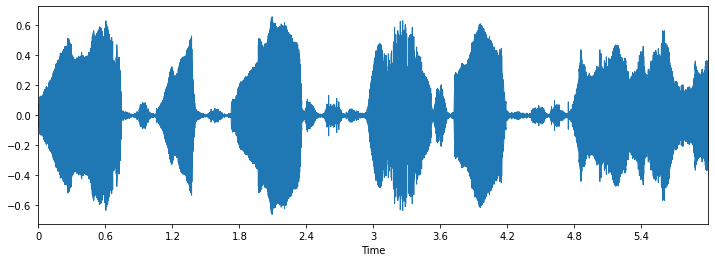

In [ ]:
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import os

# Class: awake
filename = Base_Filepath+'train/awake/awake_43_2.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

#公共函数

**变量保存至本地**

In [ ]:
import pickle
def save_variable(v,filename):
  f=open(filename,'wb')
  pickle.dump(v,f)
  f.close()
  return filename
 
def load_variavle(filename):
  f=open(filename,'rb')
  r=pickle.load(f)
  f.close()
  return r
# filename = save_variable(audiodf,'audiodf.txt')
# audiodf = load_variavle('audiodf.txt')

**Audio sample file properties**

In [ ]:
import struct

class WavFileHelper():
    def read_file_properties(self, filename):
        wave_file = open(filename,"rb")
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)


#接下来，我们将遍历每个音频样本文件并提取音频通道数、采样率和位深度。

Bit depth refers to the `color information stored` in an image. `The higher the bit depth of an image, the more colors it can store`. The simplest image, a 1 bit image, can only show two colors, black and white. That is because the 1 bit can only store one of two values, 0 (white) and 1 (black). An 8 bit image can store 256 possible colors, while a 24 bit image can display over 16 million colors. As the bit depth increases, the file size of the image also increases because more color information has to be stored for each pixel in the image.

standard sample rate used for audio CDs is` 44.1 kilohertz` (44,100 hertz).

An audio file can contain `one, two or even more Channels.` Especially in the case of surround sound, more audio Channels are needed to create the feeling of sound being

In [ ]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
import tensorflow as tf

wavfilehelper = WavFileHelper()
audiodata = []
#获取文件分类列表 
class_name_arr = tf.io.gfile.listdir(Base_Filepath+'train')
#  ['hug', 'sleepy', 'awake', 'hungry', 'diaper', 'uncomfortable']
for sigle_filename in class_name_arr:
  print(sigle_filename+" handling...")
  #获取文件目录下的文件列表
  # print(Base_Filepath+'train/'+sigle_filename)
  doc_name_arr = tf.io.gfile.listdir(Base_Filepath+'train/'+sigle_filename)
  for doc_name_item in doc_name_arr:
    # temp_filepath = os.path.join(os.path.abspath(Base_Filepath),'train/'+sigle_filename+'/',doc_name_item)
    temp_filepath = Base_Filepath+'train/'+sigle_filename+'/'+doc_name_item
    # print(temp_filepath)
    data = wavfilehelper.read_file_properties(temp_filepath)
    audiodata.append(data)
# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])
#数据存储
save_variable(audiodf,'audiodf_cnn.txt')

awake handling...
sleepy handling...
diaper handling...
hug handling...
hungry handling...
uncomfortable handling...


'audiodf_cnn.txt'

In [ ]:
audiodf = load_variavle('audiodf_cnn.txt')

**将单声道音频转换为立体声音频 **

In [ ]:
# num of channels 
print(audiodf.num_channels.value_counts(normalize=True))

1    1.0
Name: num_channels, dtype: float64


In [ ]:
# sample rates 

print(audiodf.sample_rate.value_counts(normalize=True))

16000    0.802650
44100    0.186386
1600     0.010964
Name: sample_rate, dtype: float64


In [ ]:
# bit depth

print(audiodf.bit_depth.value_counts(normalize=True))

16    1.0
Name: bit_depth, dtype: float64


**Data PreProcessing and Data Splitting**
数据  预处理 与 拆分

In [ ]:
from scipy.io import wavfile as wav
import numpy as np

# filename = './UrbanSound8K/audio/fold1/24074-1-0-7.wav' 
filename = Base_Filepath+'train/awake/awake_43_2.wav'

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate) 

Original sample rate: 16000
Librosa sample rate: 22050


Here librosa convert audio to 22.05 KHz Sample

**这里 librosa 将音频转换为 22.05 KHz 示例**

Original audio file min~max range: -25791 to 31844
Librosa audio file min~max range: -0.46381214 to 0.52137864

In [ ]:
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -21411 to 20837
Librosa audio file min~max range: -0.6605548 to 0.6336697


**Bit Depth**

This is to remove the complication because librosa function load audio in values range between -1 and 1. This is Normalization

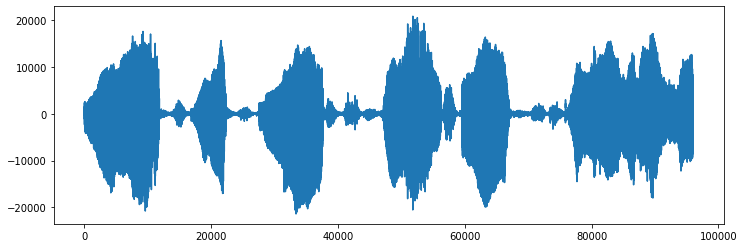

In [ ]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

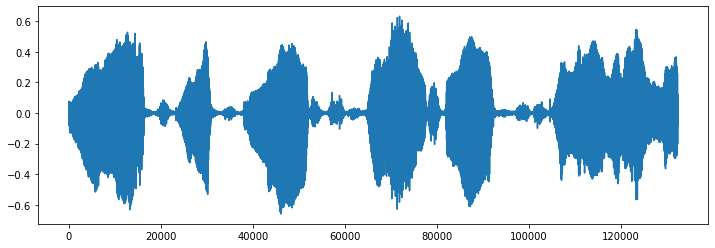

In [ ]:
# Librosa audio with channels merged 
# 通道合并
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

Librosa 的 mfcc() 函数从时间序列音频数据生成 MFCC

MFCCs是一个在语音识别和说话者识别领域被广泛运用的特征

(40, 259)


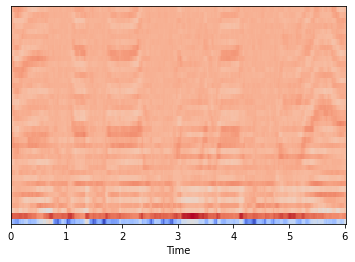

In [ ]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

**为每个文件提取MFCCs**

We will now extract an MFCC for each audio file in the dataset and store it in a Panda Dataframe along with it’s classification label.

我们现在将为数据集中的每个音频文件提取一个 MFCC，并将其与分类标签一起存储在 Panda Dataframe 中。

#使用基于CNN的方式  改进识别效果


##提取特征

In [ ]:
# max_pad_len = 174
max_pad_len = 500   #控制输入音频的长度

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    return mfccs

In [ ]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
import tensorflow as tf

wavfilehelper = WavFileHelper()
features = []
#获取文件分类列表 ['hug', 'sleepy', 'awake', 'hungry', 'diaper', 'uncomfortable']
class_name_arr = tf.io.gfile.listdir(Base_Filepath+'train')
for sigle_filename in class_name_arr:
  #获取文件目录下的文件列表
  # print(Base_Filepath+'train/'+sigle_filename)
  doc_name_arr = tf.io.gfile.listdir(Base_Filepath+'train/'+sigle_filename)
  for doc_name_item in doc_name_arr:
    # temp_filepath = os.path.join(os.path.abspath(Base_Filepath),'train/'+sigle_filename+'/',doc_name_item)
    temp_filepath = Base_Filepath+'train/'+sigle_filename+'/'+doc_name_item
    print(temp_filepath)
    class_label = sigle_filename
    data = extract_features(temp_filepath)
    features.append([data, class_label])
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
#保存变量
save_variable(featuresdf,'featuresdf_cnn.txt')
print('Finished feature extraction from ', len(featuresdf), ' files') 

In [ ]:
#获取变量值
featuresdf = load_variavle('featuresdf_cnn.txt')

##转换数据和标签  划分训练、测试集
Convert the data and labels

will use `sklearn.preprocessing.LabelEncoder` to encode the categorical text data into model-understandable numerical data

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)


##CNN Arcitechture

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
# num_columns = 174   #为什么是174
num_columns = 500   
num_channels = 1
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

(1751, 40, 500)


##加载已有模型

In [ ]:
#模型加载
import tensorflow as tf

model = tf.keras.models.load_model('saved_models/weights.best.basic_cnn.hdf5')

##编译、预估

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [ ]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 39, 499, 16)       80        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 19, 249, 16)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 19, 249, 16)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 248, 32)       2080      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 124, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 9, 124, 32)       

##开训  model.fit()

In [ ]:
from keras.callbacks import ModelCheckpoint 
import tensorflow as tf
from datetime import datetime 

# num_epochs = 12
# num_batch_size = 128
# num_epochs = 72
num_epochs = 500
num_batch_size = 256
# checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5',verbose=1, save_best_only=True)
callbacks_list=[
    tf.keras.callbacks.EarlyStopping(
        monitor='accuracy',#监控精度
        patience=15,#5轮内不改善就中止
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='saved_models/weights.best.basic_cnn.hdf5',#模型保存路径
        monitor='val_loss',#检测验证集损失值
        save_best_only=True#是否只保存最佳模型
    )
]

start = datetime.now()
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=callbacks_list, verbose=1)
model.save("saved_models/babysound_classification_tf_cnn.h5")
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/500
7/7 [==============================] - 23s 3s/step - loss: 0.3368 - accuracy: 0.8818 - val_loss: 1.0229 - val_accuracy: 0.6849
Epoch 2/500
7/7 [==============================] - 22s 3s/step - loss: 0.3473 - accuracy: 0.8726 - val_loss: 1.0016 - val_accuracy: 0.6849
Epoch 3/500
7/7 [==============================] - 21s 3s/step - loss: 0.3316 - accuracy: 0.8869 - val_loss: 1.0146 - val_accuracy: 0.6963
Epoch 4/500
7/7 [==============================] - 21s 3s/step - loss: 0.3420 - accuracy: 0.8681 - val_loss: 1.0341 - val_accuracy: 0.6621
Epoch 5/500
7/7 [==============================] - 21s 3s/step - loss: 0.3292 - accuracy: 0.8835 - val_loss: 1.0115 - val_accuracy: 0.6781
Epoch 6/500
7/7 [==============================] - 22s 3s/step - loss: 0.3370 - accuracy: 0.8744 - val_loss: 0.9839 - val_accuracy: 0.6781
Epoch 7/500
7/7 [==============================] - 21s 3s/step - loss: 0.3411 - accuracy: 0.8629 - val_loss: 1.0428 - val_accuracy: 0.6644
Epoch 8/500
7/7 [==========

##模型评估

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9754425883293152
Testing Accuracy:  0.6712328791618347


##使用模型  预测效果

In [ ]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [ ]:
def print_prediction_sta(file_name):
    prediction_feature = extract_features(file_name) 
    # print(prediction_feature)
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    # predicted_vector = model.predict_classes(prediction_feature)
    predict_x=model.predict(prediction_feature) 
    # print(predict_x)

    classes_x=np.argmax(predict_x,axis=1)
    print(classes_x)
    # predicted_class = le.inverse_transform(predicted_vector) 
    predicted_class = le.inverse_transform(classes_x) 
    # print(predicted_class)
    # print("The predicted class is:", predicted_class[0], '\n')
    return classes_x[0]

    # print("The predicted class is:", predicted_class[0], '\n') 
    # predicted_proba_vector = model.predict_proba(prediction_feature) 
    # predicted_proba = predicted_proba_vector[0]
    # for i in range(len(predicted_proba)): 
    #     category = le.inverse_transform(np.array([i]))
    #     print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

###开测

In [ ]:
filename = Base_Filepath+'train/uncomfortable/'+ 'uncomfortable_138_3_2.wav'
 
print_prediction_sta(filename)

[5]


5

In [ ]:
filename = 'test_test.wav'
 
print_prediction_sta(filename)

测试长度问题29s

In [ ]:
filename = Base_Filepath+'test/test_212.wav'
 
print_prediction_sta(filename)

In [ ]:
# Class: predict
class_name_arr = tf.io.gfile.listdir(Base_Filepath+'test')
# filename = './UrbanSound8K/audio/fold1/24074-1-0-7.wav' 
filename = Base_Filepath+'test/'+class_name_arr[2]

print_prediction(filename)


#测试集相关函数


In [ ]:
def judgelabel(labelname):
  if labelname=='sleepy':
    return 4
  elif labelname=='hug':
    return 2
  elif labelname=='uncomfortable':
    return 5
  elif labelname=='diaper':
    return 1
  elif labelname=='awake':
    return 0
  elif labelname=='hungry':
    return 3

In [ ]:
import tensorflow as tf

test_file = "./work.zip (Unzipped Files)/work/train"
class_name_arr = tf.io.gfile.listdir(test_file)
print(class_name_arr)
right_item_num = 0
wrong_item_num = 0
for index,sigle_filename in enumerate(class_name_arr):
    # print(str(index) +"handling...")
    #获取文件目录下的文件列表 并转换文件形式
    doc_name_arr = tf.io.gfile.listdir(test_file+'/'+sigle_filename)
    temp_label_index = judgelabel(sigle_filename)
    # print(temp_label_index)
    #处理每个单独的音频元素
    for doc_name_item in doc_name_arr:
      predict_label_index = print_prediction_sta(test_file+'/'+sigle_filename+'/'+doc_name_item)
      if predict_label_index==temp_label_index:
        right_item_num+=1
      else:
        wrong_item_num+=1
      # print(test_file+'/'+sigle_filename+'/'+doc_name_item)
print(right_item_num)
print(wrong_item_num)
print(right_item_num/(right_item_num+wrong_item_num))

['awake', 'diaper', 'hug', 'uncomfortable', 'sleepy', 'hungry']
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[3]
[0]
[0]
[0]
[0]
[0]
[3]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[2]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[2]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[4]
[0]
[2]
[3]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[4]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[2]
[0]
[4]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[3]
[0]
[0]
[0]
[0]
[0]
[3]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[3]
[1]
[1]
[1]
[1]
[1]
[1]
[2]
[1]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[1]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[2]
[5]
[5]
[5]
[5]
[5]
[3]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[4]
[1]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


#将测试集内容的识别数据全部存入csv文件

In [ ]:
import pandas as pd
# 打印预测
def print_prediction_arr(file_name):
    prediction_feature = extract_feature(file_name) 
    predict_x=model.predict(prediction_feature) 
    classes_x=np.argmax(predict_x,axis=1)   #返回按行查找的最大索引号
    predicted_acc=predict_x[0][classes_x[0]]
    print(predicted_acc)
    print(classes_x)
    # predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(classes_x) 
    print(predicted_class)
    print("The predicted class is:", predicted_class[0], '\n') 
    return classes_x[0],predicted_class[0],predicted_acc
# Class: predict
file_name_arr = tf.io.gfile.listdir(Base_Filepath+'test')
classes_x_arr = []
predicted_class_arr = []
predicted_acc_arr = []
for item in file_name_arr:
  filename = Base_Filepath+'test/'+item
  classes_x,predicted_class,predicted_acc=print_prediction_arr(filename)
  classes_x_arr.append(classes_x)
  predicted_class_arr.append(predicted_class)
  predicted_acc_arr.append(predicted_acc)
dataframe = pd.DataFrame({'file_name':file_name_arr,'classes_x':classes_x_arr,'predicted_class':predicted_class_arr,'predicted_acc_arr':predicted_acc_arr})

dataframe.to_csv("test_cnn.csv",index=False,sep=',')


In [ ]:
#查看样表
temp_data = pd.read_csv('test_cnn.csv')
temp_data.head()

,file_name,classes_x,predicted_class,predicted_acc_arr
0,test_20.wav,0,awake,0.846943
1,test_24.wav,0,awake,0.955788
2,test_226.wav,4,sleepy,0.580819
3,test_110.wav,1,diaper,0.994195
4,test_170.wav,5,uncomfortable,0.998955
